# Using an Artificial Neural Network for the Road Following Task

## Introduction

Nowadays, autonomous driving is getting increased attention since it can significantly reduce road accidents --SOURCE--. While it was a pure research topic in the 1980s, today many companies are developing self-driving cars. The algorithms used by autonomous driving systems can vary widely from traditional vision and robotic techniques to artificial neural networks. Considering that autonomous driving is a problem with a lot of noise and variability in the input data it is challenging to optimize traditional techniques for real world driving applications. This is why researchers developed artificial neural networks for the task of road following in the 1980s. Within the scope of this work a version of the algorithm from the paper "ALVINN: An Autonomous Land Vehicle in a Neural Network" (1988) by Pomerleau is implemented. The algorithm is an end-to-end steering system which is comprised of a 3-layer neural network predicting steering wheel angles for given street images. The neural network archieves high accuracies of up to 88% using a data set comprised of simple road following images. However, the accuracy drops significantly if the neural network is confronted with previously unseen situtations, e.g. missing lane marking.

## Theory

This section introduces the neural network for the road following task that was defined by Pomerleau in the paper "ALVINN: An Autonomous Land Vehicle in a Neural Network". 

![ALVINN Idea](graphic/ALVINN_Idea.png)

The network is a 3-layer back-propagation network that uses the data of a camera and laser range finder as an input and outputs the steering angle and thereby the direction in which the vehicle should drive. This can be seen in the graphic above. The camera input has a dimension of 30x32 pixels and only the blue color channel is used. The blue channel is chosen because it provides the best contrast between the road and the neighboring environment. The laser range finder input has a dimension of 8x32 pixels where each pixel indicates the proximity of objects in front of the car. This information can be used by the neural network to avoid crashing into obstacles on the road. Additionally, the network has a road intensity feedback unit which outputs whether the road is lighter than the surrounding environment or not. This output is given with the next input into the neural network. The input data is flattened into a vector and then fed to the input layer. The exact dimensions and the structure described here can be seen in the following graphic.

![Neural Network](graphic/AVLINN_Network.png)

The output of the neural network is 45 units that describe the steering wheel angle plus one unit for the road intensity feedback. Since the outputs are no continuous values the steering angles have to be encoded appropriately. This is done by assigning each angle to the corresponding output unit. The unit in the middle means thereby driving straight ahead and the units to the left and the right mean steering to the left or the right. The values for the output units are zero except for a "hill" around the unit to which the angle is assigned. The exact values are 0.10, 0.32, 0.61, 0.89, 1.00, 0.89, 0.61, 0.32, 0.10 and they are centered around the angle's output unit. A graphical representation can be seen in the data preprocessing section below.

### Data Set

Training a neural network requires a massive amount of labeled training data. Since collecting such a data set is time-consuming, the authors of the ALVINN paper used simulated road images to train their neural network. They generated 1200 samples with various camera orientations, lighting conditions, and noise levels.

### Training

The training of the neural network is executed through back-propagation using the 1200 simulated road images. The optimization consists of two phases. In the first phase, the road intensity unit is given random values as inputs. The goal hereby is that the road intensity output unit does not just copy the input value but deduce it from the actual image. In the second phase, after the network has learned this relationship, the road intensity input unit is given real brightness values from the previous images.

The author of the ALVINN paper stated that after 40 epochs of training the network was able to predict the correct steering angle within two units in about 90% of newly created simulated road images. Furthermore, the author tested the neural network in the NAVLAB vehicle, which is a modified Chevy van with multiple computers, a camera, and a laser range finder. The neural network was able to steer the vehicle at a speed of 1/2 meter per second on a 400-meter path across the Carnegie Mellon University (CMU) campus. The results were comparable to the best traditional vision-based road following algorithm at CMU. But the traditional algorithm needed months of manual parameter tuning, whereas the neural network learned to drive in half an hour once the data set was created.

## Implementation

This work implements and evaluates a version of the ALVINN neural network using Tensorflow and real road images from openly available data sets. Since there was no laser range finder data and no label for the road intensity unit, this implementation is only based on camera images. This is no problem for showing the general idea of the ALVINN paper. The authors concluded anyway that the laser range finder is not important as long as the vehicle is not driving off-road. Another difference is that the data set used in this work has images of the size 60x64 pixels and not 30x32. Later on, there is a comparison of how the network performs with the higher resolution compared to the lower one from the paper.

In the following the data set is loaded, preprocessed, and split into train and test data. Afterwards, the neural network is trained and evaluated on the test data.

In [3]:
# imports and configurations
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 12})

import numpy as np
np.random.seed(1)

# initialize tensorflow
import tensorflow as tf
print(f"Tensorflow version {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")
tf.random.set_seed(1)

#project_path = "/opt/project/"
project_path = ""

#import sys
#sys.path.insert(0, project_path)

Tensorflow version 2.5.0
GPU: []


## Loading the Data Set

The following code loads a data set that contains the images and the corresponding steering wheel angles from a simple test track.

In [4]:
# load data set
import h5py

X = []
y = []
with h5py.File(f"{project_path}data/track_data_2.h5", "r") as f:
    for image, label in zip(f['images'], f['angles']):
        X.append(image)
        y.append(label)

X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.float32)

print(f"Data set size: {len(X)}")
print(f"Image size: {X[0].shape}")

Data set size: 2000
Image size: (60, 64)


In [5]:
# visualize the data set
from visualization import visualize_angle_in_gif

visualize_angle_in_gif(X, y, fn="training_data_visualization")

The following video shows each image of the data set with the corresponding steering wheel angle displayed as
a green line.

![Training data visualization](graphic/training_data_visualization.gif)

Data set source: https://github.com/stephencwelch/self_driving_cars

Images minimal pixel value: 7.0
Images maximal pixel value: 255.0

Minimal steering angle: -165.42462158203125
Maximal steering angle: 23.003211975097656


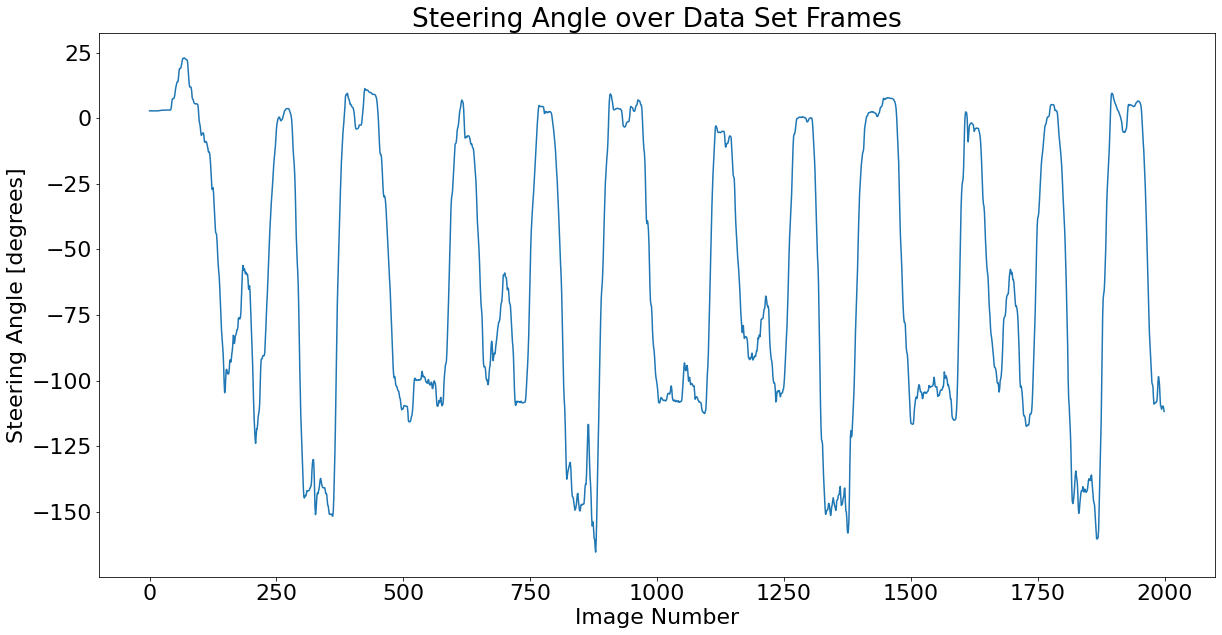

In [4]:
# exploring the data set
print(f"Images minimal pixel value: {X.min()}")
print(f"Images maximal pixel value: {X.max()}")
print()
print(f"Minimal steering angle: {y.min()}")
print(f"Maximal steering angle: {y.max()}")

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.plot(y)
plt.title("Steering Angle over Data Set Frames")
plt.ylabel("Steering Angle [degrees]")
plt.xlabel("Image Number");

## Data Set Preprocessing

Before the neural network can be trained, the input data has to be normalized.
This is done by using Min-Max normalization with a minimum of 0.0 and a maximum
of 255.0.

Furthermore, each steering wheel angle has to be assigned to one of 45 output units.
This is not simply done by one-hot encoding the assigned output unit number but by encoding
the angle with the following values 0.1, 0.32, 0.61, 0.89, 1.0, 0.89, 0.61, 0.32, 0.1.
The target output unit is the one with the 1.0 value and the ones left and right
get the other values.

Training data size: 1400


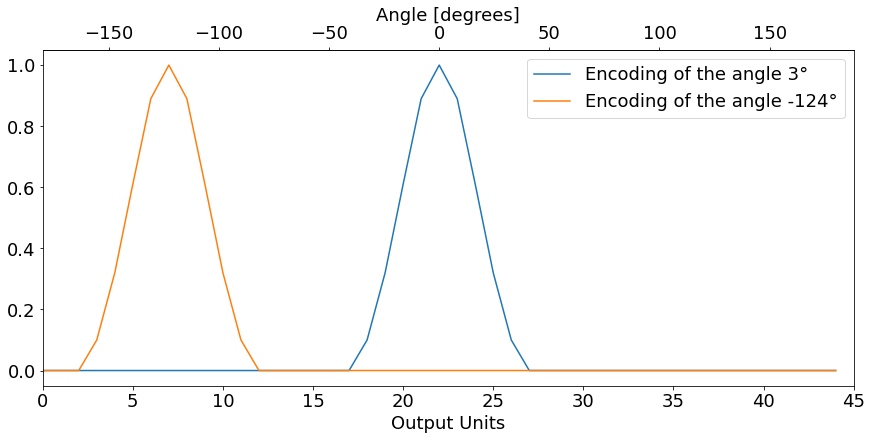

In [5]:
# data preprocessing
from sklearn.utils import shuffle

import utils

# normalize the images
X_normalized = X / 255.0

# encode the angles
y_encoded = utils.encode_angle(y, output_bins=45)

# visualize encoding
def bins(x):
    return x

def degree(x):
    degree_per_bin = 180.0 / np.floor(45 / 2.0)
    middle_bin = int(np.floor(45 / 2.0))
    return (x - middle_bin) * degree_per_bin

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_xlabel("Output Units")
ax.set_xlim([0, 45])
ax.plot(y_encoded[0], label=f"Encoding of the angle {round(y[0])}°")
ax.plot(y_encoded[300], label=f"Encoding of the angle {round(y[300])}°")

secax = ax.secondary_xaxis("top", functions=(degree,bins))
secax.set_xlabel("Angle [degrees]")
secax.set_xlim([-180, 180])
plt.legend()

# split data into train (70%) and test data (30%)
train_data_size = round(len(X) * 0.7)
print(f"Training data size: {train_data_size}")

X_train = X_normalized[:train_data_size]
y_train = y_encoded[:train_data_size]

# shuffle data before training
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_test = X_normalized[train_data_size:]
y_test = y_encoded[train_data_size:]


## Training

This section defines a version of the ALVINN neural network and trains the network on the test track data set. The accuracy is computed as defined in the ALVINN paper: If the predicted result deviates from the optimal result in at most one unit, it is seen as correctly classified.

In [6]:
# ALVINN accuracy function
def alvinn_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # compute the argmax for each output sample
    y_true_argmax = tf.math.argmax(y_true, axis=1)
    y_pred_argmax = tf.math.argmax(y_pred, axis=1)

    # 1. Subtract the argmax values and take the absolute value
    # 2. Subtract 1 from this => all correct predictions are now either 0 or -1
    # 3. Use the relu function to set all correct predictions to 0
    # 4. Count the non zero values => inverse accuracy
    count_non_zero = tf.math.count_nonzero(
        tf.nn.relu(
            tf.subtract(tf.math.abs(tf.math.subtract(y_true_argmax, y_pred_argmax)), 1)
        )
    )

    # 1. Calculate the inverse accuracy
    # 2. Subtract it from 1 => accuracy
    return tf.math.subtract(
        tf.constant(1, dtype=tf.dtypes.float64),
        tf.math.divide(
            count_non_zero, tf.size(y_true_argmax, out_type=tf.dtypes.int64)
        ),
    )

In [7]:
# model definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(60, 64)),
    tf.keras.layers.Dense(29, activation=tf.keras.activations.sigmoid),
    tf.keras.layers.Dense(45, activation=None)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[alvinn_accuracy]
              )

In [8]:
# train the neural network
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
44/44 [==============================] - 1s 1ms/step - loss: 0.0987 - alvinn_accuracy: 0.0878
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 0.0676 - alvinn_accuracy: 0.1847
Epoch 3/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0644 - alvinn_accuracy: 0.3525
Epoch 4/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0612 - alvinn_accuracy: 0.4309
Epoch 5/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0582 - alvinn_accuracy: 0.4730
Epoch 6/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0553 - alvinn_accuracy: 0.4872
Epoch 7/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0525 - alvinn_accuracy: 0.4915
Epoch 8/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0500 - alvinn_accuracy: 0.4988
Epoch 9/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0477 - alvinn_accuracy: 0.5012
Epoch 10/100
44/44 [==========================

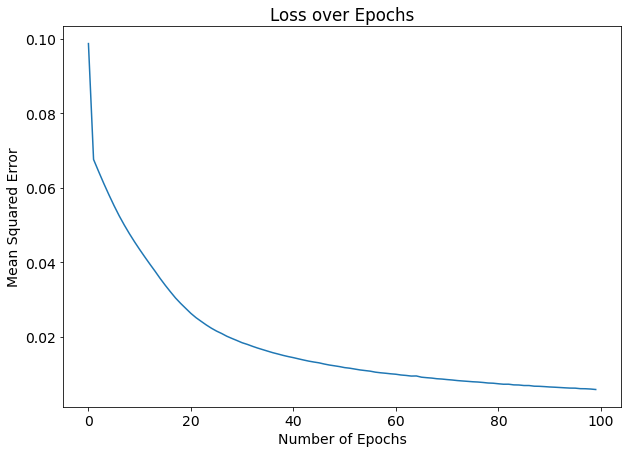

In [9]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,7))
plt.plot(history.history["loss"])
plt.title("Loss over Epochs")
plt.ylabel("Mean Squared Error")
plt.xlabel("Number of Epochs");

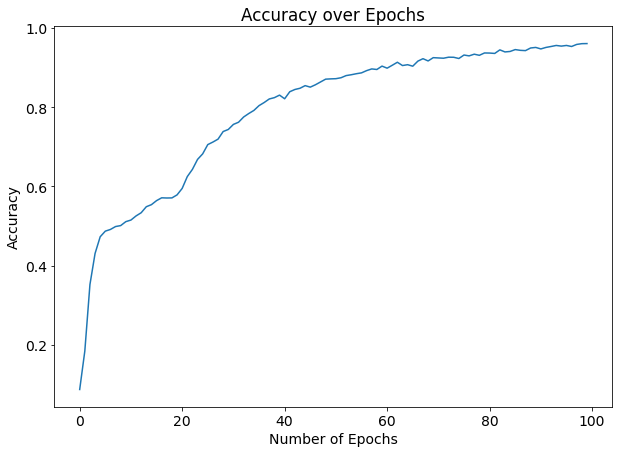

In [10]:
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10,7))
    plt.plot(history.history["alvinn_accuracy"])
    plt.title("Accuracy over Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Epochs");

## Evaluation

19/19 [==============================] - 0s 874us/step - loss: 0.0105 - alvinn_accuracy: 0.8816


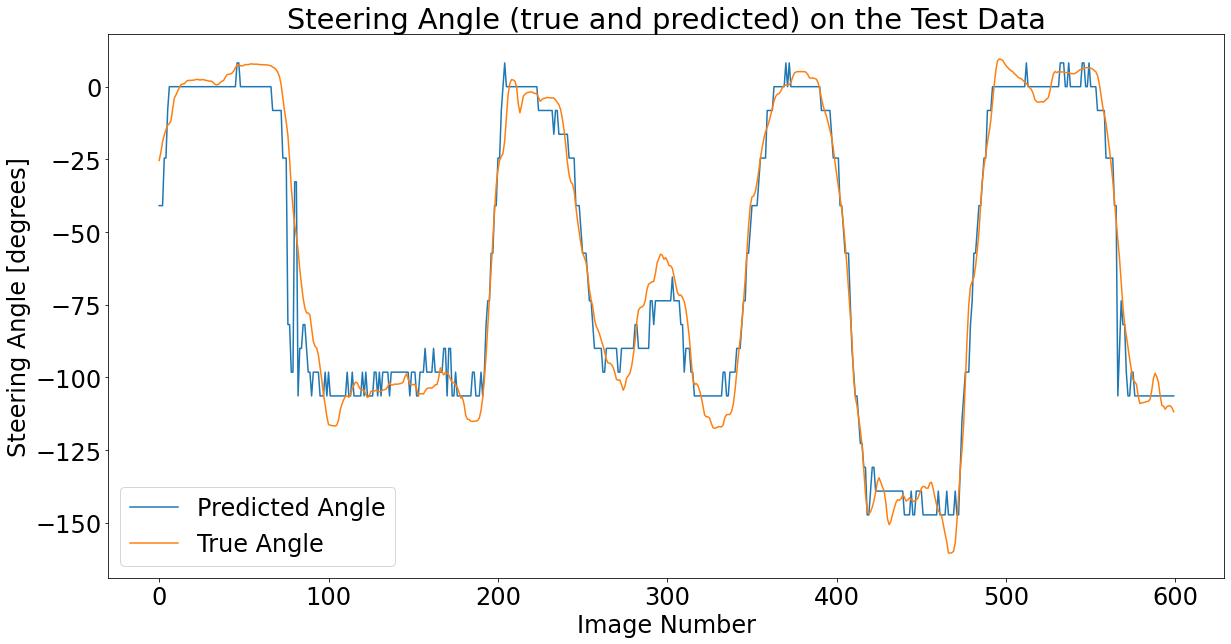

In [11]:
# testing and visualization
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

y_pred_degree = utils.decode_angle(y_pred, output_bins=45)
y_test_degree = y[train_data_size:]

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(20,10))
plt.plot(y_pred_degree, label="Predicted Angle")
plt.plot(y_test_degree, label="True Angle")
plt.legend()
plt.title("Steering Angle (true and predicted) on the Test Data")
plt.ylabel("Steering Angle [degrees]")
plt.xlabel("Image Number");

In [12]:
# visualize the performance in a video
visualize_angle_in_gif(X[train_data_size:], y_test_degree, y_pred_degree, "test_data_visualization")

![test data visualization](graphic/test_data_visualization.gif)

As it can be seen in the video above the algorithm is able to successfully steer the car on the test track.

## Network Representation
This section analyses on two example hidden units what the network has learned.

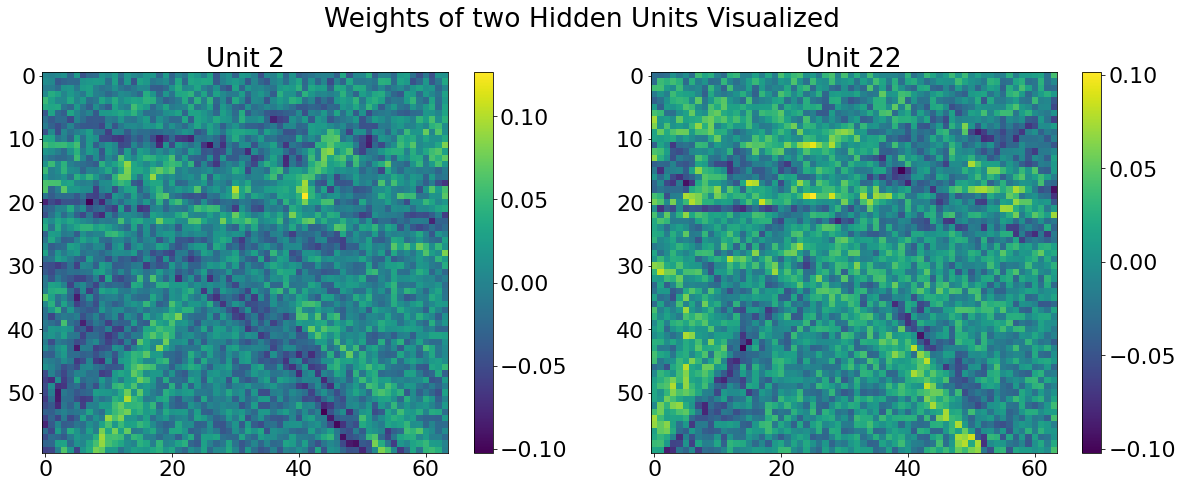

In [13]:
weights = model.layers[1].get_weights()[0]

plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Weights of two Hidden Units Visualized", y=1.01)

im = ax1.imshow(weights.T[2].reshape(60, 64))
ax1.set_title("Unit 2")
fig.colorbar(im, ax=ax1)

im = ax2.imshow(weights.T[22].reshape(60, 64))
ax2.set_title("Unit 22")
fig.colorbar(im, ax=ax2);

The images above show the weights of two hidden units. As it can be seen in the images the hidden units filter for the road marking. 

The unit in the left image filters for two straight lines because there the weights have high values. Additional, the weights for a left-skewed road marking are very low. Consequently, this unit is filtering for straight road marking.

The unit in the right image filters for left-skewed lines because there the weights have high values. Furthermore, the units for a straight road marking are low. This means that the unit on the right filters for a left-skewed road marking.

## Exploring Different Parameters

This section analyises the effects that the input size and the number of output units have on the prediction performance. To prevent code repetition the following cell contains two functions. One function is to train the ALVINN network with variable parameteres and the second one is to evaluate the trained model.

In [14]:
from data_set import DataSet, CommaAiDataSet, ReferenceDataSet


class TrainingRun:
    def __init__(
        self,
        ds: DataSet,
        input_size=None,
        output_bins=45,
        epochs=100,
        vis_ranges=[(0, 3200)],
    ):
        self.ds = ds
        self.input_size = input_size
        self.output_bins = output_bins
        self.epochs = epochs
        self.vis_ranges = vis_ranges


def train(tr: TrainingRun):
    tf.random.set_seed(1)
    np.random.seed(1)

    # load data and preprocess them
    tr.ds.preprocessing(scale=tr.input_size, output_bins=tr.output_bins)
    x_train, y_train = tr.ds.get_train_data()

    input_shape = x_train[0].shape

    # define the model
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=input_shape),
            tf.keras.layers.Dense(29, activation=tf.keras.activations.sigmoid),
            tf.keras.layers.Dense(tr.output_bins, activation=None),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[alvinn_accuracy],
    )

    # train the model
    print("---- Training ----")
    history = model.fit(x_train, y_train, epochs=tr.epochs)

    return model, history


def evaluate(model, history, tr: TrainingRun):
    print("---- Training Metrics ----")
    plt.rcParams.update({"font.size": 14})
    plt.figure(figsize=(10, 7))
    plt.plot(history.history["loss"])
    plt.title("Loss over Epochs")
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Number of Epochs")
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.plot(history.history["alvinn_accuracy"])
    plt.title("Accuracy over Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Epochs")
    plt.show()

    print("---- Testing ----")
    x_test, y_test = tr.ds.get_test_data()
    model.evaluate(x_test, y_test)
    y_pred = model.predict(x_test)

    # visualize the prediction angle
    y_pred_degree = utils.decode_angle(y_pred, output_bins=tr.output_bins)
    y_test_degree = utils.decode_angle(y_test, output_bins=tr.output_bins)

    r = len(x_test)
    x = range(r)
    plt.rcParams.update({"font.size": 24})
    plt.figure(figsize=(20, 10))
    plt.plot(x, y_pred_degree, label="y_pred")
    plt.plot(x, y_test_degree, label="y_test")
    plt.legend()
    plt.title("Steering Angle (true and predicted) on the Test Data")
    plt.ylabel("Steering Angle")

    # visualize true and predicted angle in the images
    for r in tr.vis_ranges:
        visualize_angle_in_gif(
            tr.ds.X_resized[tr.ds.train_data_length :],
            y_test_degree,
            y_pred_degree,
            fn=f"visualization_{tr.ds.__class__.__name__}_{tr.epochs}_{tr.input_size}_{tr.output_bins}_{r}".replace(
                " ", ""
            ),
            img_range=r,
        )


### Using the Original Input Size

In the ALVINN paper the input images have the size 30x32. The next cell analyzes what effect the smaller images have on the algorithm performance.

In [15]:
tr = TrainingRun(ds=ReferenceDataSet(), input_size=(32, 30), output_bins=45, epochs=100)
model, history = train(tr=tr)

---- Training ----
Epoch 1/100
44/44 [==============================] - 0s 1ms/step - loss: 0.1608 - alvinn_accuracy: 0.0121
Epoch 2/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0820 - alvinn_accuracy: 0.0705
Epoch 3/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0695 - alvinn_accuracy: 0.2519
Epoch 4/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0650 - alvinn_accuracy: 0.3438
Epoch 5/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0618 - alvinn_accuracy: 0.3816
Epoch 6/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0592 - alvinn_accuracy: 0.3875
Epoch 7/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0569 - alvinn_accuracy: 0.4233
Epoch 8/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0549 - alvinn_accuracy: 0.4276
Epoch 9/100
44/44 [==============================] - 0s 968us/step - loss: 0.0531 - alvinn_accuracy: 0.4363
Epoch 10/100
44/44 [=====

---- Training Metrics ----


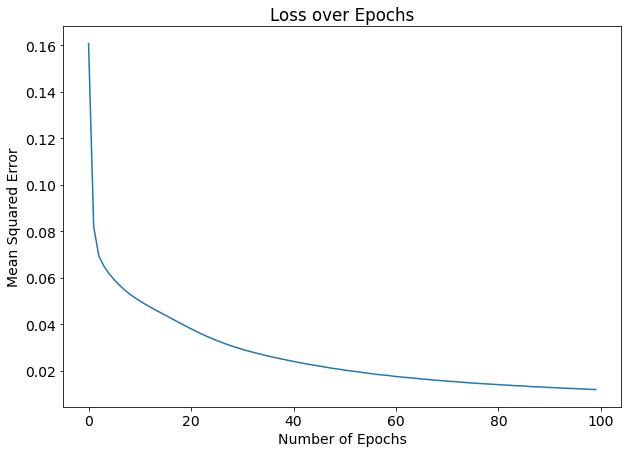

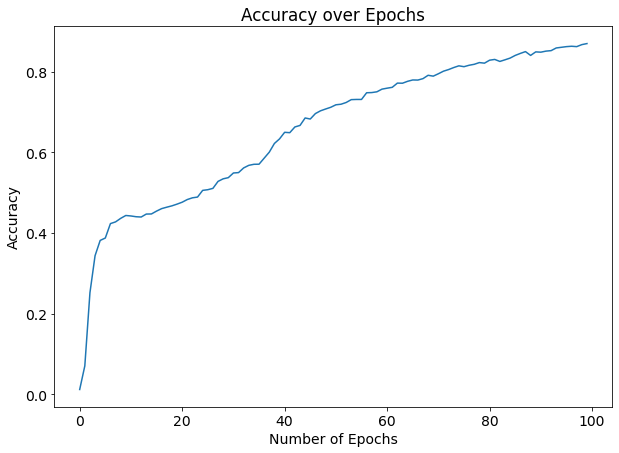

---- Testing ----
19/19 [==============================] - 0s 983us/step - loss: 0.0154 - alvinn_accuracy: 0.7670


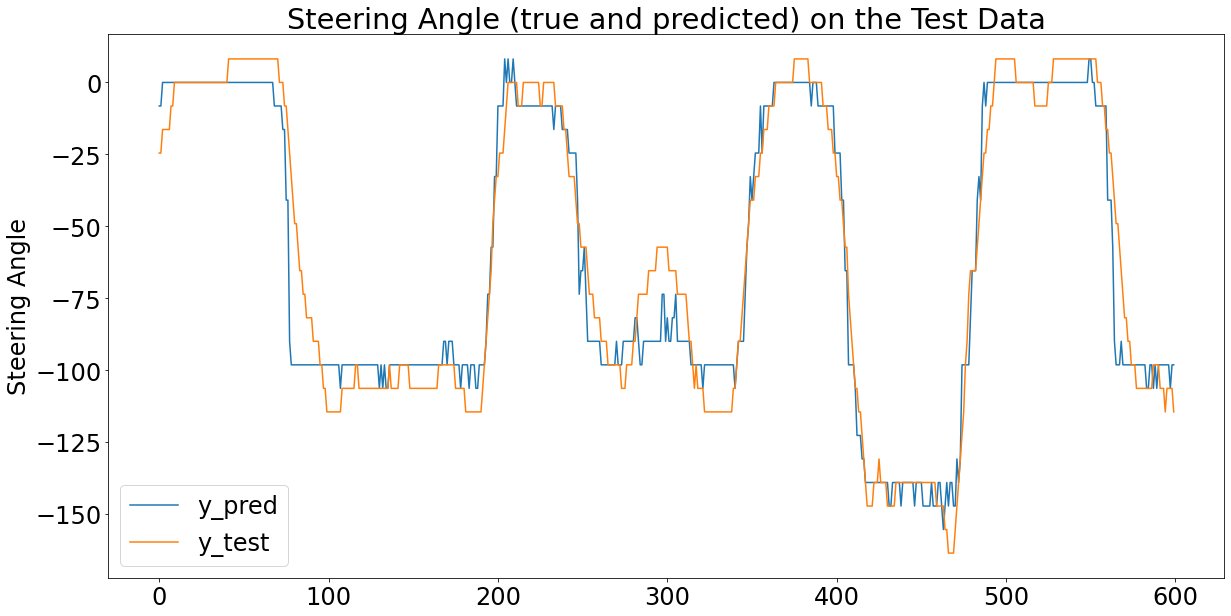

In [16]:
evaluate(model=model, history=history, tr=tr)

![Test with smaller input size](graphic/visualization_ReferenceDataSet_100_(32,30)_45_(0,3200).gif)

In the previous graphics, it can be seen that downsampling the images does have some impact on the prediction performance. The accuracy was decreased by roughly 10%. This is probably due to the fact that the number of features was reduced dramatically.

### Increasing the Number of Output Units

In [17]:
tr = TrainingRun(ds = ReferenceDataSet(), input_size=(64,60), output_bins=65, epochs=100)
model, history = train(tr=tr)

---- Training ----
Epoch 1/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0803 - alvinn_accuracy: 0.1875
Epoch 2/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0495 - alvinn_accuracy: 0.2166
Epoch 3/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0481 - alvinn_accuracy: 0.2024
Epoch 4/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0469 - alvinn_accuracy: 0.1996
Epoch 5/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0458 - alvinn_accuracy: 0.2249
Epoch 6/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0448 - alvinn_accuracy: 0.2652
Epoch 7/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0438 - alvinn_accuracy: 0.2831
Epoch 8/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0428 - alvinn_accuracy: 0.2997
Epoch 9/100
44/44 [==============================] - 0s 1ms/step - loss: 0.0419 - alvinn_accuracy: 0.3149
Epoch 10/100
44/44 [=======

---- Training Metrics ----


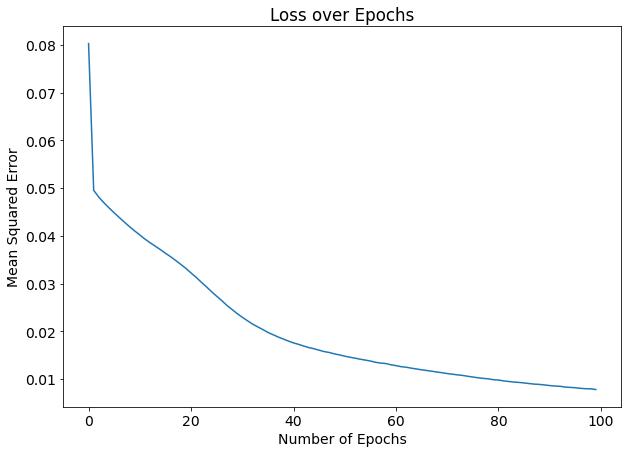

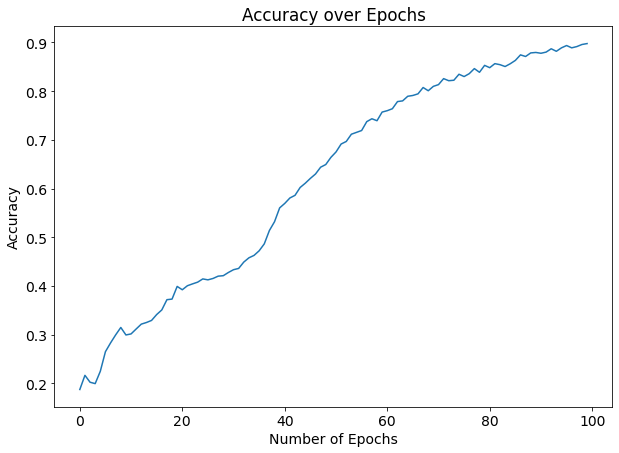

---- Testing ----
19/19 [==============================] - 0s 1ms/step - loss: 0.0116 - alvinn_accuracy: 0.7681


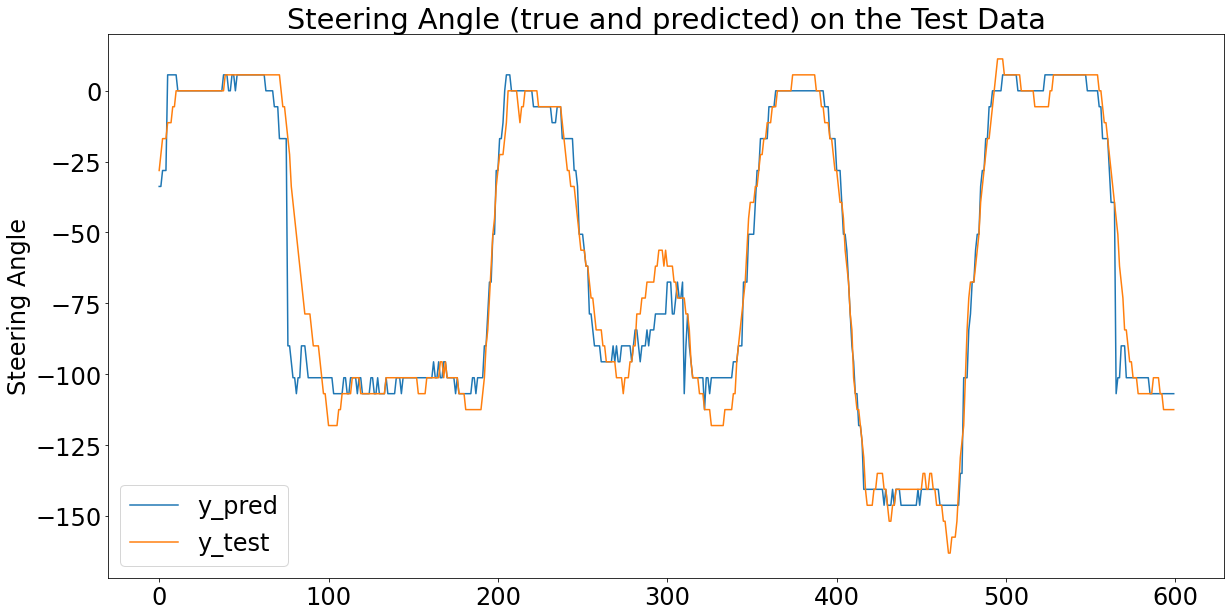

In [18]:
evaluate(model=model, history=history, tr=tr)

![Test with more output bins](graphic/visualization_ReferenceDataSet_100_(64,60)_65_(0,3200).gif)

In the graphics above it can be seen, that increasing the number of output units significantly worsens the prediction performance. This happens probably because there are more possible angles that can be predicted.

## Training on a Real World Data Set

So fare the algorithm was only trained on a simple test track with a clear road marking. This section trains and tests the performance of the ALVINN neural network on real world data. This data set was created by [comma.ai](https://research.comma.ai/) and contains mostly driving on a highway.

In [19]:
ds = CommaAiDataSet()
ds.normalize_steering_angle()
visualize_angle_in_gif(ds.X, ds.y, fn="commaai_data_set")

(18177, 3, 160, 320)
X shape: (12200, 3, 160, 320)
y shape: (12200,)


Visualization of the comma.ai data set in full resolution. The network will be trained with images resized to 60x64.

![Comma Ai Data Set](graphic/commaai_data_set.gif)

Data set source: https://research.comma.ai/

In [20]:
tr = TrainingRun(
    ds=CommaAiDataSet(),
    input_size=(64, 60),
    output_bins=45,
    epochs=30,
    vis_ranges=[(0, 209), (2214, 2774), (4010, 4878)],
)
model, history = train(tr=tr)

(18177, 3, 160, 320)
X shape: (12200, 3, 160, 320)
y shape: (12200,)
---- Training ----
Epoch 1/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0420 - alvinn_accuracy: 0.8687
Epoch 2/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0116 - alvinn_accuracy: 0.9424
Epoch 3/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0076 - alvinn_accuracy: 0.9446
Epoch 4/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0073 - alvinn_accuracy: 0.9464
Epoch 5/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0071 - alvinn_accuracy: 0.9489
Epoch 6/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0070 - alvinn_accuracy: 0.9524
Epoch 7/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0068 - alvinn_accuracy: 0.9549
Epoch 8/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0067 - alvinn_accuracy: 0.9572
Epoch 9/30
229/229 [==============================] - 0s

---- Training Metrics ----


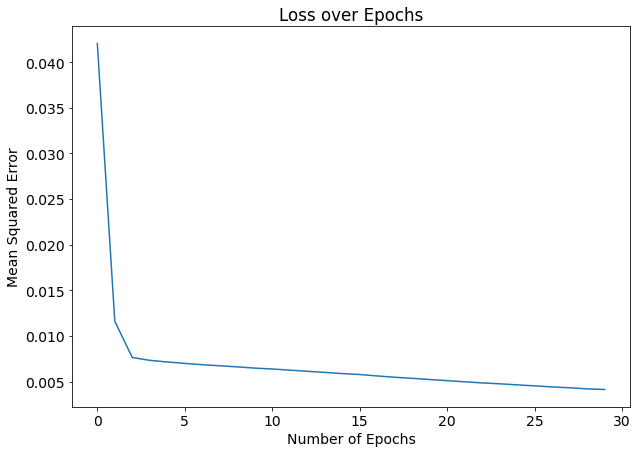

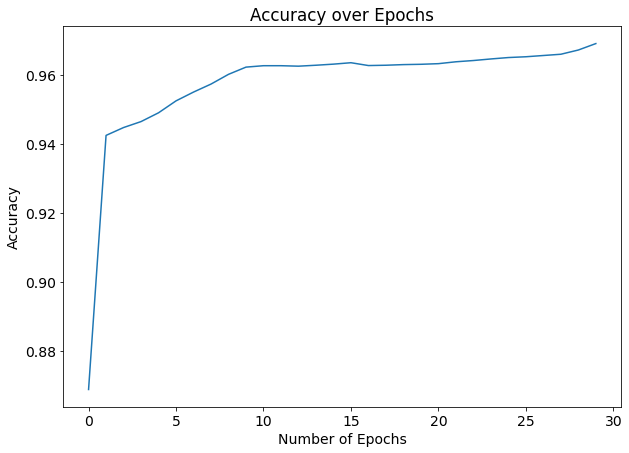

---- Testing ----
153/153 [==============================] - 0s 1ms/step - loss: 0.0135 - alvinn_accuracy: 0.9048


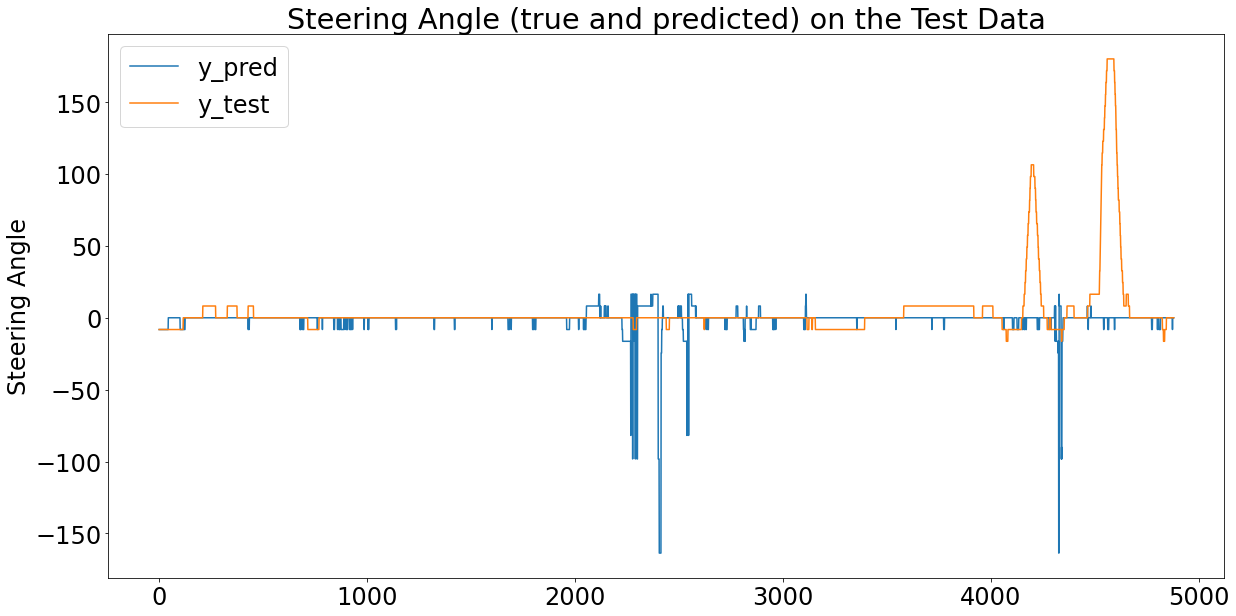

In [21]:
evaluate(model=model, history=history, tr=tr)

Evaluating the network on the test data set gives quite a good accuracy and in the video below it can be seen that the network can successfully follow the road. In this video the road marking is clearly visible and there are no cars directly in front of the car. This is a similar situation to the test track analysed previously in this work.

![Test on the Comma Ai data set](graphic/visualization_CommaAiDataSet_30_(64,60)_45_(0,209).gif)

The next video shows cars coming into the lane from the right side. In this situation the network performs poorly because it wants to steer hard to the left which does not make sense. This happens probably due to the fact that the network did not see such a situation very often during training. Additionally the right road marking is not visible. Since the network filter for the left and right road marking this makes the prediction worse.

![Test on the Comma Ai data set](graphic/visualization_CommaAiDataSet_30_(64,60)_45_(2214,2774).gif)

The last video shows another interesting situation. In this part of the test data the car leaves the highway and turns into a housing area. Since the network has not seen such data during the training in cannot predict a correct angle anymore. Hence the network will only perform good if it is trained with a lot of data from various driving situations. This is probably one of the biggest drawbacks of this approach to autonomous driving.

![Test on the Comma Ai data set](graphic/visualization_CommaAiDataSet_30_(64,60)_45_(4010,4878).gif)

### Using a Lower Resolution on the Real World Data Set

In this section the ALVINN network is once again trained on the real world data set but the input and output dimensions are aligned with those from the paper.

In [22]:
tr = TrainingRun(ds=CommaAiDataSet(), input_size=(32,30), output_bins=45, epochs=30)
model, history = train(tr=tr)

(18177, 3, 160, 320)
X shape: (12200, 3, 160, 320)
y shape: (12200,)
---- Training ----
Epoch 1/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0569 - alvinn_accuracy: 0.8757
Epoch 2/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0136 - alvinn_accuracy: 0.9407
Epoch 3/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0083 - alvinn_accuracy: 0.9438
Epoch 4/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0079 - alvinn_accuracy: 0.9439
Epoch 5/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0078 - alvinn_accuracy: 0.9440
Epoch 6/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0077 - alvinn_accuracy: 0.9443
Epoch 7/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0076 - alvinn_accuracy: 0.9444
Epoch 8/30
229/229 [==============================] - 0s 1ms/step - loss: 0.0075 - alvinn_accuracy: 0.9443
Epoch 9/30
229/229 [==============================] - 0s

---- Training Metrics ----


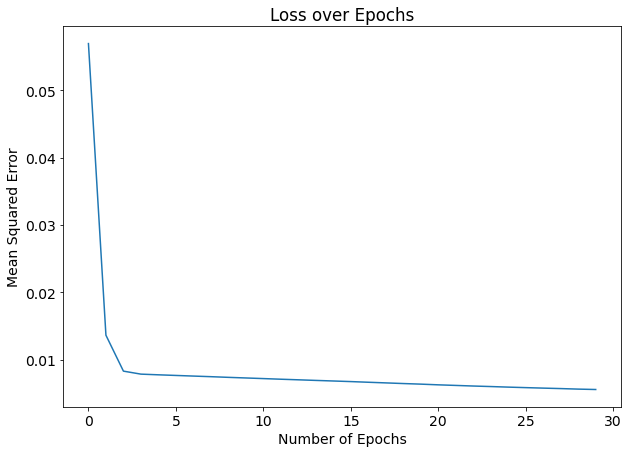

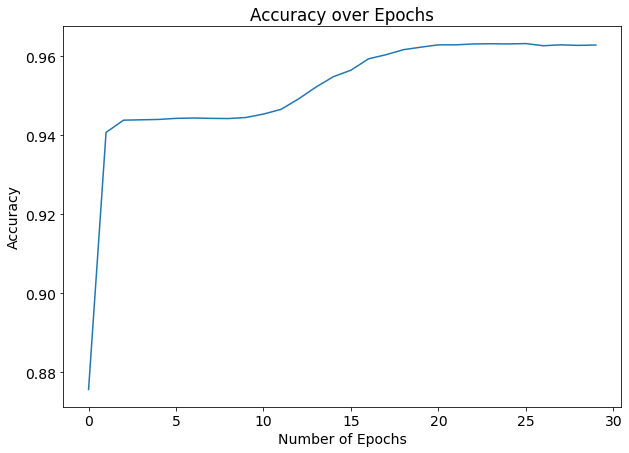

---- Testing ----
153/153 [==============================] - 0s 885us/step - loss: 0.0110 - alvinn_accuracy: 0.9289


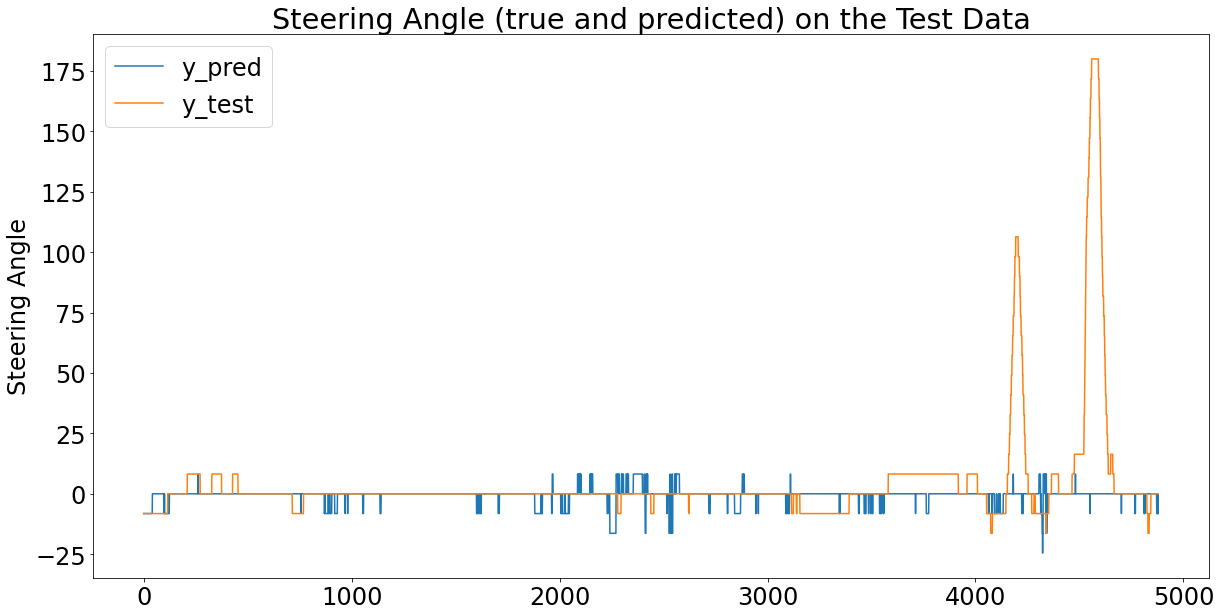

In [23]:
evaluate(model=model, history=history, tr=tr)

![Low resolution on comma ai data set](graphic/visualization_CommaAiDataSet_30_(32,30)_45_(0,3200).gif)

The graphics above show that the performance is roughly the same despite the decreased input image size. This is probably the case because the steering wheel angle does not move much on the highway. Thus predicting an angle around zero gives mostly a good result. The decreased input image size would probably have a higher impact on the accuracy if the car would drive on a more curvy road. This would then be similar to the test track shown previously in this work and there the prediction performance got worse with a smaller input image size.

## Discussion

This work showed that it is possible to sucessfully steer a car using a neural network. The main advantages of this approach are that it is less susceptible to noise and that the development is easy and fast once an appropriated data set is collected. Furthermore it is easy to assimilate different sensors, for example, camera and laser range finder as it is done in the ALVINN network.

One of the biggest drawback of this approach is that the neural network will only be able to drive in similar conditions as it was trained in. This is visible at the end of the real world data set test where the car drives into the housing area. Since the network is trained only with images from the highway it cannot predict an accurate steering wheel angle in this situation. Additionally the data set should not only contain examples of perfect driving but should also contain examples of how to return to the road center if the driver makes a mistake.
Another problem arises on crossroads and road forks because there are multiple possible travel directions. This can result in an oscillation between two very different directions.

## Summary

- mehr summary weniger ausblick

Neural network based end-to-end steering systems are a powerful tool for autonomous driving if they are trained with a sufficient amount of real-world data. While this approach to autonomous driving is currently probably too unpredictable for cities, it could be quite interesting for road following on highways or in remote areas. With more sophisticated models it could be possible in the future to also navigate in more complex situations with neural networks. NVIDIA, for example, trained a convolutional neural network (CNN) to successfully steer a car in a wide variety of situations. They used a data set with 72 hours of driving on different road types and under different weather conditions to optimize the network. Another example with a similar approach is the company comma.ai. They already sell hardware to equip existing vehicles with self-driving car hardware making the cars able to navigate autonomously on highways.

## Sources

- Pomerleau, Dean A (1989). Alvinn: An autonomous land vehicle in a neural network
- Test track data set: https://github.com/stephencwelch/self_driving_cars
- Real world data set: https://research.comma.ai/
- Mariusz, Davide, Daniel, Bernhard, et al. (2016). End to End Learning for Self-Driving Cars